### Mean Reversion Portfolio with OU process

Assume we have a mean reverting portfolio that holds a position $\alpha = \frac{A}{S_0^{(1)}}$ in a risky asset $S^{(1)}$ and a short position $\beta = \frac{B}{S_0^{(2)}}$ in a similar behaving asset $S^{(2)}$. The portfolio value can be calculated as follows:

$$X_{t}^{\alpha, \beta} = \alpha S^{(1)} - \beta S^{(2)}, t \geq 0$$

We assume that the two assets $S^{(1)}$ and $S^{(2)}$ have a statistical correlation that makes them move together (it can be considered that they are in a cointegration relationship).

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

START_DATE = '2015-01-01'
END_DATE = pd.to_datetime('today')
TICKER = ['005930.KS','005935.KS']

data = yf.download(
    TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = '1d',
    progress = False
)['Close']

The cointegration test (coint) is based on the Engle-Granger two-step method. The test statistic is calculated as $t_{\gamma} = \frac{\hat{\gamma}}{SE(\hat{\gamma})}$ where $\hat{\gamma}$ is the coefficient estimate from the ADF regression on residuals. The p-value is obtained by comparing the test statistic to the MacKinnon critical values. The score represents the test statistic value, while the p-value indicates the probability of observing the test statistic under the null hypothesis of no cointegration.

1. First step regression:
$y_t = βx_t + ε_t$

2. Second step - Augmented Dickey-Fuller test on residuals:
$Δε_t = α + γε_{t-1} + δ_1Δε_{t-1} + ... + δ_pΔε_{t-p} + u_t$

Where:
- $y_t$ and $x_t$ are the time series being tested
- $β$ is the cointegration coefficient
- $ε_t$ are the residuals from the first regression
- $γ$ is the coefficient of interest (if $γ < 0$, suggests cointegration)
- $p$ is the number of lagged difference terms
- $u_t$ is the error term

The null hypothesis $H0: γ = 0$ (no cointegration)
The alternative $H1: γ < 0$ (cointegration exists)


The score represents the test statistic value, while the p-value indicates the probability of observing the test statistic under the null hypothesis of no cointegration. We can get these values using statsmodels.tsa.stattools.coint() function which returns (score, pvalue, crit_value).




### Cointegration (coint) is a statistical property of time series that measures whether two or more non-stationary series move together over time, maintaining a long-term equilibrium relationship despite short-term deviations.

Key characteristics:
1. Cointegrated series share a common stochastic trend
2. Their linear combination is stationary (mean-reverting)
3. Useful for pairs trading strategies

Mathematical formulation:
For two series $X_t$ and $Y_t$, if there exists $\beta$ such that:
$Y_t - \beta X_t = \epsilon_t$
where $\epsilon_t$ is stationary (I(0)), then $X_t$ and $Y_t$ are cointegrated

Practical implications:
- Cointegrated pairs tend to revert to their mean relationship
- Spread between cointegrated assets can be traded
- Useful for statistical arbitrage strategies

Testing procedure:
1. Check if both series are I(1) (non-stationary)
2. Run cointegration test (e.g., Engle-Granger)
3. If p-value < threshold (e.g., 0.05), series are cointegrated



In [2]:
from statsmodels.tsa.stattools import coint
# The p-value represents the probability of observing the test statistic under the null hypothesis of no cointegration
# A low p-value (typically < 0.05) suggests we can reject the null hypothesis and conclude the series are cointegrated

score, p_value, _ = coint(
    data['005930.KS'].pct_change().dropna(), 
    data['005935.KS'].pct_change().dropna()
)
print('Correlation : %.4f' % data['005930.KS'].pct_change().dropna().corr(data['005935.KS'].pct_change().dropna()))
print('Cointegration test p-value : %.4f' % p_value)
print('Cointegration test score : %.4f'  % score)

Correlation : 0.8465
Cointegration test p-value : 0.0000
Cointegration test score : -24.4617


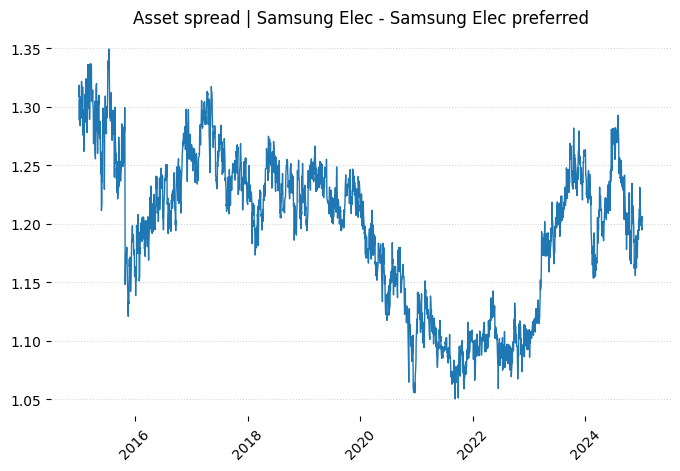

In [3]:
spread = data['005930.KS'] / data['005935.KS']

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    spread.index,
    spread,
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title('Asset spread | Samsung Elec - Samsung Elec preferred')
plt.show()

#### In the case of a sideways market

The Samsung Electronics - Samsung Electronics Preferred pair showed a sideways trend between 2017 and 2019, allowing us to perform simulations as shown below

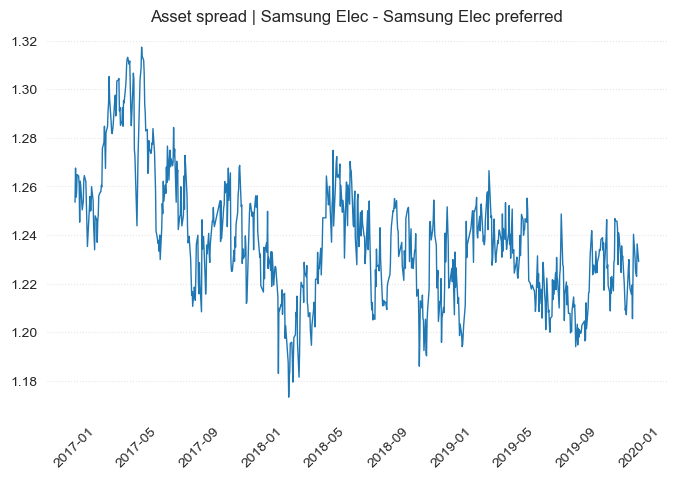

In [54]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    spread.loc['2017':'2019'].index,
    spread.loc['2017':'2019'],
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title('Asset spread | Samsung Elec - Samsung Elec preferred')
plt.show()

In [55]:
from quant_free.finml.backtest.backtest_synthetic_data import *

params = get_OU_params(spread.loc['2017':'2019'])
print(params)

{'forecast': 0.21277011864553097, 'phi': 0.9198357340601951, 'sigma': 0.00808180171396156, 'half life': 8.29518585965048}


In [95]:
rPT = rSLm = np.linspace(0, 10, 41)
nIter = int(1e5)
maxHP = 20
seed = spread.loc['2017':'2019'].mean()

phi = 2 ** (-1. / params['half life'])
forecast = params['forecast']
sigma = params['sigma'] * 100

In [96]:
output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

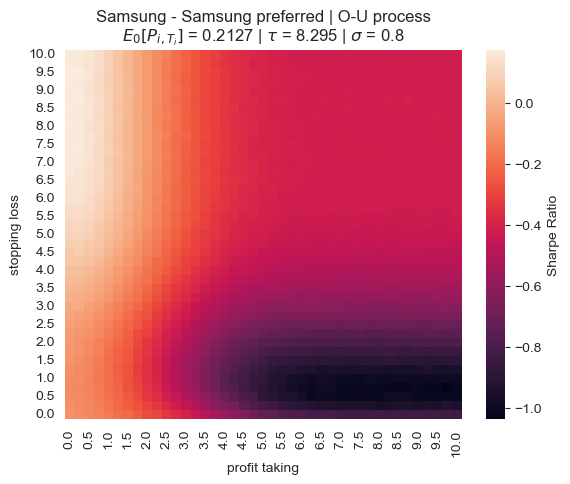

In [97]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Samsung - Samsung preferred | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0.2127 | $\tau$ = 8.295 | $\sigma$ = 0.8')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()

#### 양의 상승장인 경우

2023년은 두 자산의 스프레드가 상승하는 국면이다.

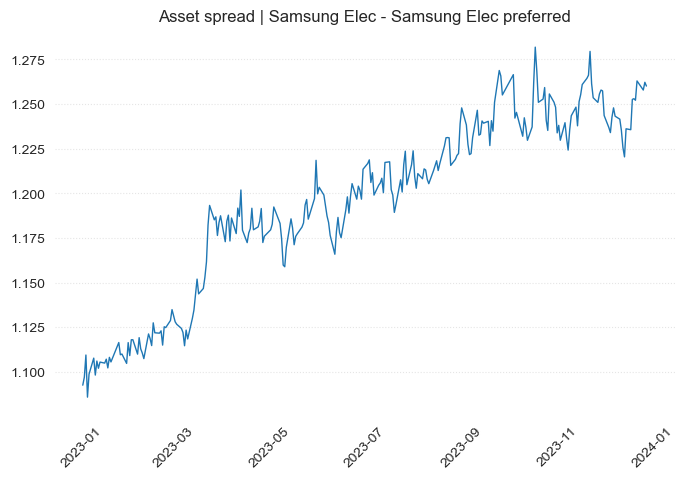

In [35]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    spread.loc['2023'].index,
    spread.loc['2023'],
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title('Asset spread | Samsung Elec - Samsung Elec preferred')
plt.show()

In [36]:
params = get_OU_params(spread.loc['2023'])
print(params)

{'forecast': 0.177525785331679, 'phi': 0.9759724689414349, 'sigma': 0.00785313738994158, 'half life': 28.5000617381229}


In [37]:
rPT = rSLm = np.linspace(0, 10, 41)
nIter = int(1e5)
maxHP = 20
seed = spread.loc['2023'].mean()

phi = 2 ** (-1. / params['half life'])
forecast = params['forecast']
sigma = params['sigma'] * 100

In [38]:
output = synthetic_simulation(phi, forecast, sigma, nIter, maxHP, rPT, rSLm, seed)
sharpe_grid = get_sharpe_grid(output, rPT, rSLm)

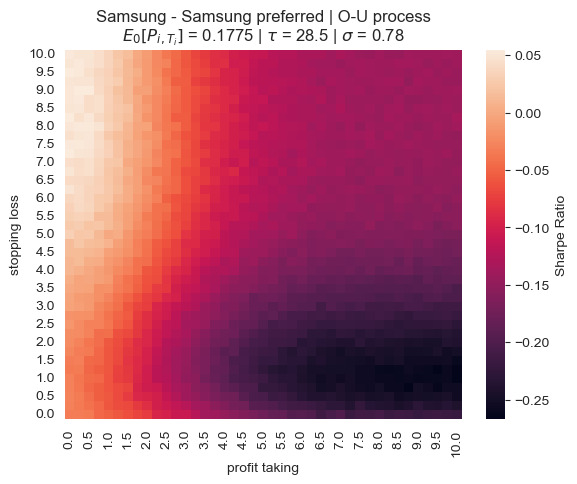

In [40]:
sns.heatmap(sharpe_grid, cbar_kws={"label": "Sharpe Ratio"})
plt.title('Samsung - Samsung preferred | O-U process\n'+r'$E_0[P_{i, T_i}]$ = 0.1775 | $\tau$ = 28.5 | $\sigma$ = 0.78')
plt.xlabel('profit taking')
plt.ylabel('stopping loss')
plt.show()